In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [3]:
transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
class_names=sorted(os.listdir('/kaggle/input/brain-tumor-classification/Training'))
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [5]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.train_dir = "/kaggle/input/brain-tumor-classification/Training"
        self.test_dir = "/kaggle/input/brain-tumor-classification/Testing"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        trainset = datasets.ImageFolder(root=self.train_dir, transform=self.transform)
        testset = datasets.ImageFolder(root=self.test_dir, transform=self.transform)

        self.train_dataset = DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(testset, batch_size=self.batch_size)
        
    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [6]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [7]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=100)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7512690424919128     │
│         test_loss         │     4.960132122039795     │
└───────────────────────────┴───────────────────────────┘

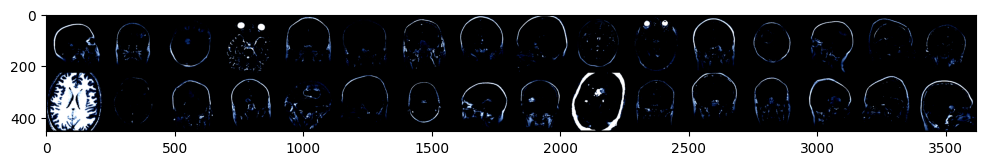

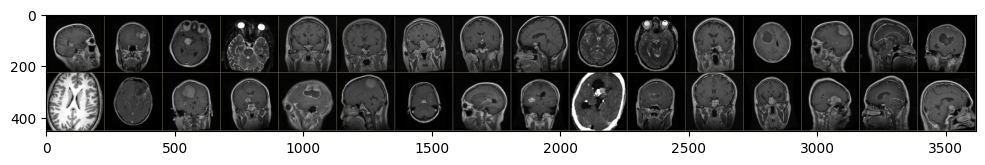

In [8]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [9]:
device = torch.device("cpu")

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                  precision    recall  f1-score   support

    glioma_tumor     0.7857    0.2200    0.3437       100
meningioma_tumor     0.6667    0.9913    0.7972       115
        no_tumor     0.7664    1.0000    0.8678       105
 pituitary_tumor     0.9138    0.7162    0.8030        74

        accuracy                         0.7462       394
       macro avg     0.7831    0.7319    0.7029       394
    weighted avg     0.7699    0.7462    0.7020       394

